In [1]:
from fastai.text.all import *
import polars as pl

In [2]:
pl.Config.set_fmt_str_lengths(200);

# Classic methods

## Dataset

Reconocimiento de emociones

> A dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise. For more detailed information please refer to the paper below.
>
> The authors constructed a set of hashtags to collect a separate dataset of English tweets from the Twitter API belonging to eight basic emotions, including anger, anticipation, disgust, fear, joy, sadness, surprise, and trust. The data has already been preprocessed based on the approach described in their paper

- [Dataset original](https://github.com/dair-ai/emotion_dataset)
- En estos notebooks vamos a usar un subset del dataset publicado en [kaggle](https://www.kaggle.com/datasets/parulpandey/emotion-dataset/data)

In [3]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
df = (
    pl.concat([
        pl.scan_csv('emotions-dataset/training.csv').with_columns(is_valid=False),
        pl.scan_csv('emotions-dataset/validation.csv').with_columns(is_valid=True),
    ])
    .with_columns(pl.col.label.replace_strict(labels_dict).alias('label_name'))
    .collect()
)
print(df.shape)
df.head()

(18000, 4)


text,label,is_valid,label_name
str,i64,bool,str
"""i didnt feel humiliated""",0,false,"""sadness"""
"""i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake""",0,false,"""sadness"""
"""im grabbing a minute to post i feel greedy wrong""",3,false,"""anger"""
"""i am ever feeling nostalgic about the fireplace i will know that it is still on the property""",2,false,"""love"""
"""i am feeling grouchy""",3,false,"""anger"""


In [4]:
df['is_valid'].value_counts()

is_valid,count
bool,u32
true,2000
false,16000


In [5]:
(
    df['label_name']
    .value_counts()
    .with_columns((pl.col.count/pl.col.count.sum()).alias('perc'))
    .sort('perc', descending=True)
)

label_name,count,perc
str,u32,f64
"""joy""",6066,0.337
"""sadness""",5216,0.289778
"""anger""",2434,0.135222
"""fear""",2149,0.119389
"""love""",1482,0.082333
"""surprise""",653,0.036278


In [6]:
df['text'].str.len_chars().describe()

statistic,value
str,f64
"""count""",18000.0
"""null_count""",0.0
"""mean""",96.679333
"""std""",55.786339
"""min""",7.0
"""25%""",53.0
"""50%""",86.0
"""75%""",129.0
"""max""",300.0


### Vectorize

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
df

text,label,is_valid,label_name
str,i64,bool,str
"""i didnt feel humiliated""",0,false,"""sadness"""
"""i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake""",0,false,"""sadness"""
"""im grabbing a minute to post i feel greedy wrong""",3,false,"""anger"""
"""i am ever feeling nostalgic about the fireplace i will know that it is still on the property""",2,false,"""love"""
"""i am feeling grouchy""",3,false,"""anger"""
…,…,…,…
"""im having ssa examination tomorrow in the morning im quite well prepared for the coming exam and somehow i feel numb towards exam because in life there is much more important things than exam""",0,true,"""sadness"""
"""i constantly worry about their fight against nature as they push the limits of their inner bodies for the determination of their outer existence but i somehow feel reassured""",1,true,"""joy"""
"""i feel its important to share this info for those that experience the same thing""",1,true,"""joy"""


In [9]:
x_train,y_train = df.filter(~pl.col.is_valid).pipe(lambda d: (d['text'], d['label_name']))
x_valid,y_valid = df.filter(pl.col.is_valid).pipe(lambda d: (d['text'], d['label_name']))
x_train.shape, x_valid.shape

((16000,), (2000,))

In [10]:
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(x_train[:5])
x

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 47 stored elements and shape (5, 41)>

In [11]:
vectorizer.get_feature_names_out()

array(['about', 'am', 'and', 'around', 'awake', 'being', 'can', 'cares',
       'damned', 'didnt', 'ever', 'feel', 'feeling', 'fireplace', 'from',
       'go', 'grabbing', 'greedy', 'grouchy', 'hopeful', 'hopeless',
       'humiliated', 'im', 'is', 'it', 'just', 'know', 'minute',
       'nostalgic', 'on', 'post', 'property', 'so', 'someone', 'still',
       'that', 'the', 'to', 'who', 'will', 'wrong'], dtype=object)

In [12]:
x[0].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.61418897,
        0.        , 0.49552379, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.61418897, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [13]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english')
vectorizer

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,analyzer,'word'
,stop_words,'english'
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [14]:
x_train_vec = vectorizer.fit_transform(x_train)
x_train_vec

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 101945 stored elements and shape (16000, 3151)>

In [15]:
x_valid_vec = vectorizer.transform(x_valid)
x_valid_vec

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12418 stored elements and shape (2000, 3151)>

In [16]:
vectorizer.get_feature_names_out()

array(['abandoned', 'abilities', 'ability', ..., 'youve', 'zero', 'zone'],
      shape=(3151,), dtype=object)

In [17]:
L(vectorizer.get_stop_words())

(#318) ['each','same','and','nevertheless','eg','us','after','you','along','towards','because','onto','within','two','whole','detail','name','fifty','co','ten'...]

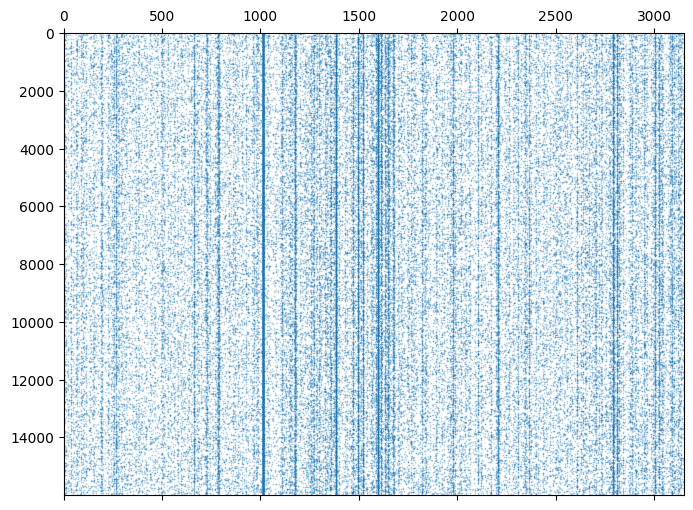

In [18]:
fig,ax = plt.subplots(figsize=(8,6))
ax.spy(x_train_vec.toarray(), markersize=0.10, aspect='auto');

## Model

### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
rf = RandomForestClassifier(200, max_depth=5)
rf.fit(x_train_vec, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [34]:
rf_preds = rf.predict(x_valid_vec)

In [35]:
rf_accuracy = (rf_preds==y_valid.to_numpy()).mean()
rf_accuracy

np.float64(0.3545)

### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
log_reg = LogisticRegression()
log_reg.fit(x_train_vec, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [25]:
log_reg_preds = log_reg.predict(x_valid_vec)

In [26]:
log_reg_accuracy = (log_reg_preds==y_valid.to_numpy()).mean()
log_reg_accuracy

np.float64(0.879)

### Results

In [36]:
df_results = pl.DataFrame({
    'text': x_valid,
    'label': y_valid,
    'rf_preds': rf_preds,
    'log_reg_preds': log_reg_preds,
})
df_results.sample(5)

text,label,rf_preds,log_reg_preds
str,str,str,str
"""i feel like im not being loyal to my boyfriend even though i have not acted on my feelings for this guy""","""love""","""joy""","""love"""
"""i hate him and the feeling is pretty mutual i find him obnoxious and he thinks im a bitch once again it has nothing to do with what happened and nobody thinks less of anybody because of it""","""anger""","""joy""","""anger"""
"""i have would be that common ground but i always feel like i m a casual observer rather than an enthusiast""","""joy""","""joy""","""joy"""
"""i cant even believe that i have reached a half century young and feel so terrific""","""joy""","""joy""","""joy"""
"""ive never been particularly bothered about my age or the ageing process and while i feel slightly surprised that im nearly i dont really mind""","""surprise""","""joy""","""anger"""


In [37]:
df_results.pipe(lambda d: {k:(d['label']==d[k]).mean() for k in d.columns[2:]})

{'rf_preds': 0.3545, 'log_reg_preds': 0.879}

In [45]:
(
    df_results
    .filter(pl.col.label!=pl.col.log_reg_preds)
    .sample(3)
)

text,label,rf_preds,log_reg_preds
str,str,str,str
"""id let you kill it now but as a matter of fact im not feeling frightfully well today""","""joy""","""joy""","""sadness"""
"""i really want to watch it for the obvious romance reasons and i have a feeling like it would be a really funny kind of drama too i can also somewhat relate to the female main character who works with …","""surprise""","""joy""","""sadness"""
"""i am going to several holiday parties and i can t wait to feel super awkward i am going to several holiday parties and i can t wait to feel super awkward a href http badplaydate""","""joy""","""joy""","""sadness"""


In [48]:
(
    df_results
    .group_by('label')
    .agg(
        pl.len(),
        (pl.col.label==pl.col.rf_preds).mean().alias('rf_accuracy'),
        (pl.col.label==pl.col.log_reg_preds).mean().alias('log_reg_accuracy'),
    )
    .sort('label')
)

label,len,rf_accuracy,log_reg_accuracy
str,u32,f64,f64
"""anger""",275,0.0,0.847273
"""fear""",212,0.0,0.778302
"""joy""",704,1.0,0.943182
"""love""",178,0.0,0.724719
"""sadness""",550,0.009091,0.929091
"""surprise""",81,0.0,0.691358


## Bonus: NMF

In [49]:
from sklearn.decomposition import NMF

In [70]:
nmf = NMF(n_components=6)
nmf

,n_components,6
,init,None
,solver,'cd'
,beta_loss,'frobenius'
,tol,0.0001
,max_iter,200
,random_state,None
,alpha_W,0.0
,alpha_H,'same'
,l1_ratio,0.0
,verbose,0


In [71]:
x_train_nmf = nmf.fit_transform(x_train_vec, y_train)
x_train_nmf.shape

(16000, 6)

In [72]:
nmf.components_.shape

(6, 3151)

In [73]:
def top_words(row, topk=10):
    vocab = vectorizer.get_feature_names_out()
    return [vocab[o] for o in np.argsort(row)[-topk:][::-1]]

top_words(nmf.components_[0])

['feeling',
 'little',
 'bit',
 'ive',
 'pretty',
 'today',
 'left',
 'quite',
 'remember',
 'overwhelmed']

In [74]:
for o in nmf.components_:
    print(top_words(o))

['feeling', 'little', 'bit', 'ive', 'pretty', 'today', 'left', 'quite', 'remember', 'overwhelmed']
['like', 'ive', 'life', 'missed', 'person', 'feels', 'hated', 'things', 'supporting', 'doing']
['im', 'sure', 'going', 'today', 'right', 'generous', 'feeling', 'excited', 'starting', 'say']
['just', 'right', 'thinking', 'need', 'wanted', 'makes', 'didnt', 'content', 'want', 'said']
['really', 'good', 'didnt', 'bad', 'got', 'new', 'felt', 'hard', 'things', 'doing']
['know', 'want', 'dont', 'people', 'don', 'time', 'think', 'love', 'life', 'make']


![NMF](pics/nmf.png)
(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

## Bonus: stemming

In [ ]:
import nltk
nltk.download('wordnet')
from nltk import stem

[nltk_data] Downloading package wordnet to /home/renato/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
porter = stem.porter.PorterStemmer()
[porter.stem(word) for word in ['organize', 'organizes', 'organizing']]

['organ', 'organ', 'organ']

## Bonus: lemmatization

In [ ]:
wnl = stem.WordNetLemmatizer()
[wnl.lemmatize(word) for word in ['organize', 'organizes', 'organizing']]

['organize', 'organizes', 'organizing']